In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

import sys; sys.path.insert(0, '..') # add parent folder path where discrepancies folder is

from discrepancies import datasets, pool, pool2graph, evaluation, discrepancies_intervals, pool2graph_cat_FJ2_2

RANDOM_STATE = 42

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_openml
data = fetch_openml(data_id=554, return_X_y=False)
X = data.data
y = data.target
idx = np.random.choice(range(X.shape[0]), 10000)
X = X.iloc[idx, :]
y = y.iloc[idx]

idx0, idx1 = np.where(y == '0'), np.where(y == '8')
idx = list(idx0[0])
idx.extend(list(idx1[0]))
X = X.iloc[idx, :]
y = y.iloc[idx]
y = (y== '8').astype('int')
#y = pd.get_dummies(y)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [22]:
X_train.shape

(1369, 784)

In [3]:
pool1 = pool.BasicPool(models=["RF200", "RF100"])
pool1 = pool1.fit(X_train.values, y_train)

preds = pool1.predict(X_test)
from sklearn.metrics import accuracy_score

print("Accuracies (F1): ", {c: accuracy_score(y_test, preds[c]) for c in preds.columns})
print("Discrepancies on train:", pool1.predict_discrepancies(X_train).mean())
print("Discrepancies on test:", pool1.predict_discrepancies(X_test).mean())


Accuracies (F1):  {'RF100': 0.9812925170068028, 'RF200': 0.9880952380952381}
Discrepancies on train: 0.009495982468955442
Discrepancies on test: 0.006802721088435374


Ce truc ne sert à rien: si je fais rien de l'espace latent, le réseau n'apprend rien (il apprend la fonction identité, logique).Il faudrait peut être un VAE plutôt.

In [10]:
from tqdm.notebook import tqdm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.datasets import make_moons
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


dataset_train = TensorDataset(torch.Tensor(X_train.values),torch.Tensor(y_train.values))
dataset_test = TensorDataset(torch.Tensor(X_test.values),torch.Tensor(y_test.values))
train_loader = DataLoader(dataset_train, batch_size=30000, shuffle=False, drop_last=False)
test_loader = DataLoader(dataset_test, batch_size=30000, shuffle=False, drop_last=False)

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.enc1 = nn.Linear(X_train.shape[1], 512)
        self.enc2 = nn.Linear(512, 256)
        self.enc3 = nn.Linear(256, 128)
        self.enc4 = nn.Linear(128, 5 * 2)
        
        self.dec1 = nn.Linear(5, 128)
        self.dec2 = nn.Linear(128, 256)
        self.dec3 = nn.Linear(256, 512)
        self.dec4 = nn.Linear(512, X_train.shape[1])
        
    def encode(self, x):
        h1 = torch.relu(self.enc1(x))
        h2 = torch.relu(self.enc2(h1))
        h3 = torch.relu(self.enc3(h2))
        h4 = torch.sigmoid(self.enc4(h3))
        return h4
    
    def decode(self, x):
        h1 = torch.relu(self.dec1(x))
        h2 = torch.relu(self.dec2(h1))
        h3 = torch.relu(self.dec3(h2))
        h4 = torch.sigmoid(self.dec4(h3))
        return h4
        
    def forward(self, x):
        Z = self.encode(x)
        Xhat = self.decode(Z)
        return Xhat, Z



class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x, z
    
    
    
    
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader):#tqdm(, total=int(X_train.shape[0]/dataloader.batch_size)):
        x, y = data
        xhat, z = model(x)
        optimizer.zero_grad()
        loss = criterion(xhat, x)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss




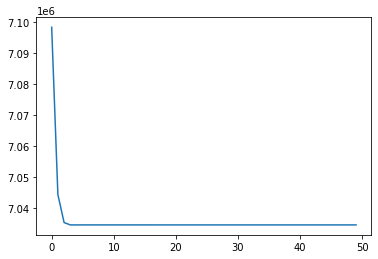

In [11]:

modelf = Autoencoder().cpu()
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(modelf.parameters(), lr=0.01)

N_EPOCHS = 50

train_loss = []
for epoch in range(N_EPOCHS):
    #print(f"Epoch {epoch+1} of {N_EPOCHS}")
    train_epoch_loss = fit(modelf, train_loader)
    #val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    
    
plt.plot(train_loss)



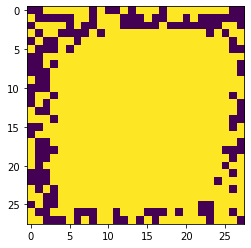

In [23]:
modelf.eval()
for x, y in train_loader:
    xhat, z = modelf(x)
    plt.imshow(to_img(xhat.cpu().data).detach().numpy()[1300].reshape(28, 28))
    break
#Z_dataset = pd.DataFrame(z.detach().numpy())
    

In [195]:
modelf.eval()
for x, y in train_loader:
    xhat, z = modelf(x)
Z_dataset = pd.DataFrame(z.detach().numpy())
    
img1_z = z[0]
img1_x = x[0]
img1_y = y[0]

from sklearn.metrics import pairwise_distances_argmin
pairwise_distances_argmin(img1_z.detach().numpy().reshape(1, -1),  Z_dataset.values[np.where(y_train!=int(y[0].detach().numpy()))[0], :])


tensor([1346., 1346., 1346., 1346., 1346., 1346., 1346.,    0., 1346., 1346.],
       grad_fn=<SumBackward1>)


array([0])

In [190]:
Z_dataset.values[np.where(y_train!=int(y[0].detach().numpy()))[0], :]

array([[1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 0., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 0., 1., 1.]], dtype=float32)

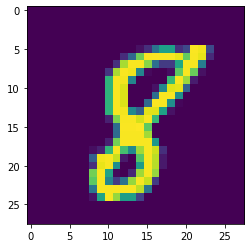

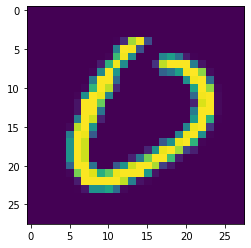

In [167]:
plt.imshow(img1_x.reshape(28,28))
plt.show()
plt.imshow(x.detach().numpy()[np.where(y_train==0)[0][0], :].reshape(28,28))


In [319]:
%%time 
p2g = pool2graph_cat_FJ2_2.pool2graph(Z_dataset, y_train, pool1, k_init=10, categorical_names=cat_names)
#p2g = pool2graph.pool2graph(X_train, y_train, pool1, k_init=3)

p2g.fit(max_epochs=5)#5?
print(len(p2g.G.nodes))

INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5


118060
CPU times: user 1min 39s, sys: 6.74 s, total: 1min 46s
Wall time: 1min 12s


In [320]:
from discrepancies import discrepancies_intervals
intervals = discrepancies_intervals.get_discrepancies_intervals(p2g.G)
print(len(intervals))

15647


# Start2

In [ ]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from torch.autograd import Variable
from tqdm.notebook import tqdm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.datasets import make_moons
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


num_epochs = 50
batch_size = 128
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MNIST('./data', transform=img_transform, download=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [352]:
train_data_np = to_img(dataset.train_data).numpy().reshape(60000, -1)
train_labels_np = dataset.train_labels.numpy()

test_data_np = to_img(dataset.test_data).numpy().reshape(60000, -1)
test_labels_np = dataset.test_labels.numpy()


In [353]:
%%time

pool1 = pool.BasicPool(models=["RF200", "XGB"])
pool1 = pool1.fit(train_data_np, train_labels_np)

preds = pool1.predict(test_data_np)

from sklearn.metrics import accuracy_score

print("Accuracies (F1): ", {c: accuracy_score(test_labels_np, preds[c]) for c in preds.columns})
print("Discrepancies on train:", pool1.predict_discrepancies(train_data_np).mean())
print("Discrepancies on test:", pool1.predict_discrepancies(test_data_np).mean())


[19:10:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracies (F1):  {'RF200': 0.9473833333333334, 'XGB': 1.0}
Discrepancies on train: 0.052616666666666666
Discrepancies on test: 0.052616666666666666
CPU times: user 1h 45min 9s, sys: 44.2 s, total: 1h 45min 53s
Wall time: 11min 4s


In [89]:
preds = pool1.predict(test_data_np)

from sklearn.metrics import accuracy_score

print("Accuracies (F1): ", {c: accuracy_score(test_labels_np, preds[c]) for c in preds.columns})
print("Discrepancies on train:", pool1.predict_discrepancies(train_data_np).mean())
print("Discrepancies on test:", pool1.predict_discrepancies(test_data_np).mean())


Accuracies (F1):  {'RF100': 0.7440333333333333, 'RF200': 0.9655666666666667}
Discrepancies on train: 0.23645
Discrepancies on test: 0.23645


In [17]:

N_LATENT = 5

class autoencoder_fc(nn.Module):
    def __init__(self):
        super(autoencoder_fc, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, N_LATENT))
        self.decoder = nn.Sequential(
            nn.Linear(N_LATENT, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 28 * 28), nn.Tanh())
        
    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x, z

class autoencoder_conv(nn.Module):
    def __init__(self):
        super(autoencoder_conv, self).__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, N_LATENT)
        )
        self.decoder_lin = nn.Sequential(
            nn.Linear(N_LATENT, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1),
            nn.Tanh()
        )
        
    def encoder(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
    def decoder(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        #x = nn.Tanh(x) ### pq sigmoid?
        return x

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x, z


model = autoencoder_conv()#.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    loss = 0
    for data in dataloader:
        img, _ = data
        #img = img.view(img.size(0), -1)
        img = Variable(img)#.cuda()
        # ===================forward=====================
        output, _ = model(img)
        loss_b = criterion(output, img)
        loss += loss_b
        # ===================backward====================
        optimizer.zero_grad()
        loss_b.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './mlp_img/image_{}.png'.format(epoch))


epoch [1/50], loss:116.9248
epoch [2/50], loss:56.5764
epoch [3/50], loss:51.6694
epoch [4/50], loss:49.3925
epoch [5/50], loss:47.8860
epoch [6/50], loss:46.7349
epoch [7/50], loss:45.8715
epoch [8/50], loss:45.1100
epoch [9/50], loss:44.5041
epoch [10/50], loss:44.0765
epoch [11/50], loss:43.6306
epoch [12/50], loss:43.2183
epoch [13/50], loss:42.8654
epoch [14/50], loss:42.5805
epoch [15/50], loss:42.3275
epoch [16/50], loss:42.0588
epoch [17/50], loss:41.8160
epoch [18/50], loss:41.6358
epoch [19/50], loss:41.4494
epoch [20/50], loss:41.2653
epoch [21/50], loss:41.1275
epoch [22/50], loss:40.9879
epoch [23/50], loss:40.8135
epoch [24/50], loss:40.6867
epoch [25/50], loss:40.5835
epoch [26/50], loss:40.4658
epoch [27/50], loss:40.3639
epoch [28/50], loss:40.2411
epoch [29/50], loss:40.1617
epoch [30/50], loss:40.0713
epoch [31/50], loss:39.9916
epoch [32/50], loss:39.8651
epoch [33/50], loss:39.7667
epoch [34/50], loss:39.7032
epoch [35/50], loss:39.6178
epoch [36/50], loss:39.6185


torch.Size([1, 1, 28, 28])


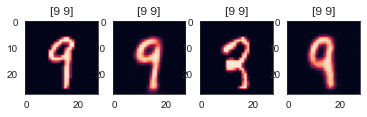

> /var/folders/yk/z4rr9hd95kl7lwp6502rfxcm0000gn/T/ipykernel_68777/55493213.py(12)<module>()
     10 
     11 
---> 12 for data in dataloader:
     13         img, y = data
     14         #img = img.view(img.size(0), -1) # à décommenter si FC. Commenter si conv

ipdb> c
torch.Size([1, 1, 28, 28])


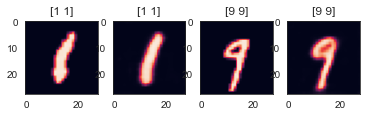

> /var/folders/yk/z4rr9hd95kl7lwp6502rfxcm0000gn/T/ipykernel_68777/55493213.py(12)<module>()
     10 
     11 
---> 12 for data in dataloader:
     13         img, y = data
     14         #img = img.view(img.size(0), -1) # à décommenter si FC. Commenter si conv

ipdb> q


BdbQuit: 

In [493]:
from sklearn.metrics import pairwise_distances_argmin

def get_img_and_info(idx):
    img = to_img(img.cpu().data).detach().numpy()[idx]
    
def get_preds(img):
    return {"preds_clf":pool1.predict(img.flatten().reshape(1, -1)),
           "disc": pool1.predict_discrepancies(img.flatten().reshape(1, -1))}

    
    
for data in dataloader:
        img, y = data
        #img = img.view(img.size(0), -1) # à décommenter si FC. Commenter si conv
        img = Variable(img)#.cuda()
        # ===================forward=====================
        output, latent = model(img)
        idxA = 0
        imgA = to_img(img.cpu().data).detach().numpy()[idxA]
        predsA = get_preds(imgA)
        ZA = latent[idxA]
        #imgZA = to_img(output.cpu().data).detach().numpy()[idxA]
        print(to_img(model.decoder(ZA.reshape(1, -1))).shape)
        imgZA = to_img(model.decoder(ZA.reshape(1, -1))).detach().numpy()
        yA = y[idxA]
        predsZA = get_preds(imgZA)
        
        while (predsA["disc"].values[0] == 1) or (predsZA["disc"].values[0] == 1) or (predsA["preds_clf"].values.mean() != yA):
            idxA += 1
            imgA = to_img(img.cpu().data).detach().numpy()[idxA]
            predsA = get_preds(imgA)
            ZA = latent[idxA]
            #imgZA = to_img(output.cpu().data).detach().numpy()[idxA]
            imgZA = to_img(model.decoder(ZA.reshape(1, -1))).detach().numpy()
            yA = y[idxA]
            predsZA = get_preds(imgZA)
            
        
        conditions = np.where((y != yA))# * (pool1.predict_discrepancies(to_img(img).detach().numpy()aze == 0.0)))
        otherclasses = latent[conditions]
        idxB = pairwise_distances_argmin(ZA.flatten().reshape(1, -1).detach().numpy(), otherclasses.detach().numpy())
        imgB = to_img(img.cpu().data[conditions]).detach().numpy()[idxB]
        ZB = otherclasses[idxB]
        yB = y[conditions][idxB]
        #imgZB = to_img(output.cpu().data).detach().numpy()[conditions][idxB]
        imgZB = to_img(model.decoder(ZB.reshape(1, -1))).detach().numpy()
        
        
        
        _, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
        ax1.imshow(imgA.reshape(28, 28))
        ax1.set_title(str(predsA['preds_clf'].values[0]))
        ax2.imshow(imgZA.reshape(28, 28))
        ax2.set_title(str(pool1.predict(imgZA.flatten().reshape(1, -1)).values[0]))
        ax3.imshow(imgB.reshape(28, 28))
        ax3.set_title(str(pool1.predict(imgB.flatten().reshape(1, -1)).values[0]))
        ax4.imshow(imgZB.reshape(28, 28))
        ax4.set_title(str(pool1.predict(imgZB.flatten().reshape(1, -1)).values[0]))
        plt.show()
        import pdb;pdb.set_trace()

6 new images


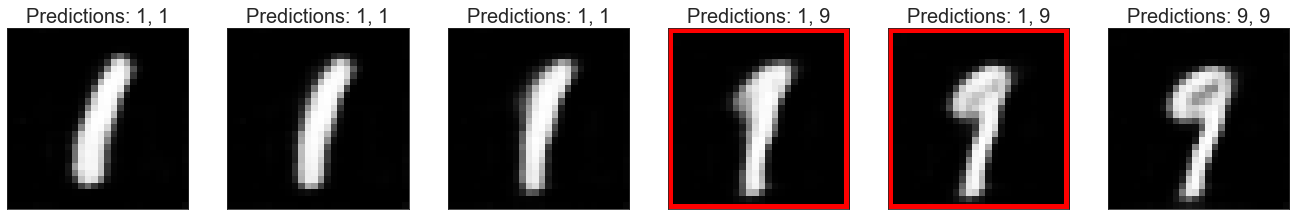

In [495]:
import seaborn as sns
import matplotlib.patches as patches
#sns.set_palette('mako')
sns.set_style("white")
N_SEGMENT = 5
#_alphas = np.random.random(N_SEGMENT)
_alphas = np.array((range(0, N_SEGMENT+1)))/N_SEGMENT
#_alphas.sort()
new_imgs= []
new_preds = []
discrs = []
for alpha in _alphas:
    newZ = (1-alpha) * ZA + alpha *ZB
    new_img = to_img(model.decoder(newZ))
    new_pred = get_preds(new_img.detach().numpy())
    
    #if (alpha == 0.0) or (alpha == 1.0) or (new_pred["disc"].values == 1):
    new_imgs.append(new_img)
    new_preds.append(new_pred["preds_clf"].values[0])
    discrs.append(new_pred["disc"].values)

    
print("%i new images"%len(new_imgs))
fig, ax = plt.subplots(1, len(new_imgs), sharex=True, sharey=True)
fig.set_size_inches(18.5, 3)

for idx in range(len(new_imgs)):
    
    ax[idx].tick_params(labelbottom=False, labelleft=False)
    ax[idx].imshow(new_imgs[idx].detach().numpy().reshape(28, 28), cmap=plt.get_cmap('gray'))
    ax[idx].set_title('Predictions: %i, %i'%(new_preds[idx][0], new_preds[idx][1]), fontsize=20)
    if discrs[idx] == True:
        rect = patches.Rectangle((-0.5 , -0.5),28, 28, fill=False, color='red', linewidth=10)
        ax[idx].add_patch(rect)
plt.tight_layout()

plt.savefig('../../results/illustration_MNIST6_19_g.pdf')

In [307]:
get_preds(model.decoder(ZA.reshape(1, -1)).detach().numpy())

{'preds_clf':    RF100  RF200
 0      7      7,
 'disc': 0    0
 dtype: int64}

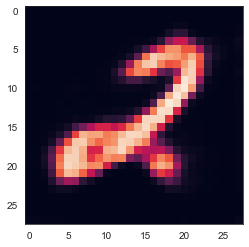

In [329]:
plt.imshow(model.decoder(ZA.reshape(1, -1)).detach().numpy()[0, 0] )

(array([643.,  21.,  10.,  12.,   9.,  10.,   8.,  17.,  21.,  33.]),
 array([7.5995922e-06, 9.6636117e-02, 1.9326463e-01, 2.8989315e-01,
        3.8652167e-01, 4.8315018e-01, 5.7977873e-01, 6.7640722e-01,
        7.7303576e-01, 8.6966425e-01, 9.6629280e-01], dtype=float32),
 <BarContainer object of 10 artists>)

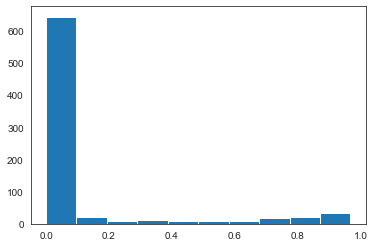

In [396]:
plt.hist(to_img(model.decoder(ZA.reshape(1, -1))).detach().numpy()[0, 0].flatten())

(array([576.,  24.,  25.,  13.,  13.,  16.,  13.,  21.,  28.,  55.]),
 array([1.7285347e-06, 9.7409733e-02, 1.9481774e-01, 2.9222575e-01,
        3.8963374e-01, 4.8704174e-01, 5.8444977e-01, 6.8185776e-01,
        7.7926576e-01, 8.7667376e-01, 9.7408175e-01], dtype=float32),
 <BarContainer object of 10 artists>)

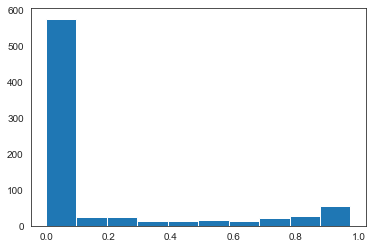

In [393]:
plt.hist(imgZA.flatten())